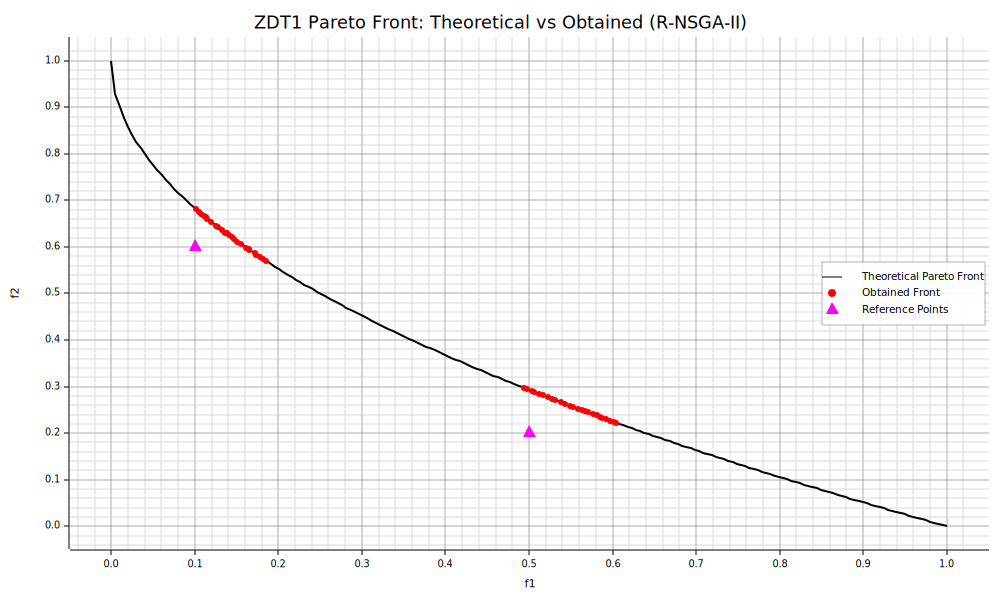

In [3]:
:dep ndarray = "*"
:dep moors = "*"
:dep plotters = "0.3.6"

use ndarray::{s, array, Array2, Axis, Ix2};
use moors::{
    impl_constraints_fn,
    algorithms::Rnsga2Builder,
    duplicates::CloseDuplicatesCleaner,
    operators::{GaussianMutation, RandomSamplingFloat, ExponentialCrossover},
    genetic::Population,
};
use plotters::prelude::*

/// Evaluate the ZTD1 objectives in a fully vectorized manner.
fn evaluate_ztd1(x: &Array2<f64>) -> Array2<f64> {
    let n = x.nrows();
    let m = x.ncols();

    // clamp to [0,1] to mirror the Python domain constraints
    let clamped = x.mapv(|v| v.clamp(0.0, 1.0));

    let f1 = clamped.column(0).to_owned();
    let tail = clamped.slice(s![.., 1..]);
    let sums = tail.sum_axis(Axis(1));
    let g = sums.mapv(|s| 1.0 + 9.0 / ((m as f64) - 1.0) * s);
    let ratio = &f1 / &g;
    let f2 = &g * (1.0 - ratio.mapv(|r| r.sqrt()));

    let mut out = Array2::<f64>::zeros((n, 2));
    out.column_mut(0).assign(&f1);
    out.column_mut(1).assign(&f2);
    out
}

/// Compute the theoretical Pareto front for ZTD1.
fn ztd1_theoretical_front() -> (Vec<f64>, Vec<f64>) {
    let mut f1_theo = Vec::with_capacity(200);
    let mut f2_theo = Vec::with_capacity(200);
    for i in 0..200 {
        let v = i as f64 / 199.0;
        f1_theo.push(v);
        f2_theo.push(1.0 - v.sqrt());
    }
    (f1_theo, f2_theo)
}

// Create constraints using the macro impl_constraints_fn
impl_constraints_fn!(BoundConstraints, lower_bound = 0.0, upper_bound = 1.0);



// Set up RNSGA-II algorithm with epsilon = 0.005
let population: Population<Ix2, Ix2> = {
    // Define two reference points (for example, points on the Pareto front)
    let rp: Array2<f64> = array![[0.5, 0.2], [0.1, 0.6]];
    let epsilon = 0.005;

    let mut algorithm = Rnsga2Builder::default()
        .sampler(RandomSamplingFloat::new(0.0, 1.0))
        .crossover(ExponentialCrossover::new(0.75))
        .mutation(GaussianMutation::new(0.1, 0.01))
        .reference_points(rp)
        .epsilon(epsilon)
        .fitness_fn(evaluate_ztd1)
        .constraints_fn(BoundConstraints)
        .duplicates_cleaner(CloseDuplicatesCleaner::new(1e-8))
        .num_vars(30)
        .population_size(50)
        .num_offsprings(50)
        .num_iterations(700)
        .mutation_rate(0.1)
        .crossover_rate(0.9)
        .keep_infeasible(false)
        .verbose(false)
        .seed(1729)
        .build()
        .expect("Failed to build RNSGA-II");

    // Run the algorithm
    algorithm.run().expect("RNSGA2 run failed");
    algorithm.population.unwrap().clone()
};

// Compute the theoretical Pareto front for ZTD1
let (f1_theo, f2_theo) = ztd1_theoretical_front();

// Get the best Pareto front obtained (as a Population instance)
let fitness = population.fitness;

// Extract the obtained fitness values (each row is [f1, f2])
let f1_found: Vec<f64> = fitness.column(0).to_vec();
let f2_found: Vec<f64> = fitness.column(1).to_vec();

// Compute the theoretical Pareto front for ZTD1
let (f1_theo, f2_theo) = ztd1_theoretical_front();

// Plot the theoretical Pareto front, obtained front, and reference points
let mut svg = String::new();
{
    let backend = SVGBackend::with_string(&mut svg, (1000, 600));
    let root = backend.into_drawing_area();
    root.fill(&WHITE).unwrap();

    let grid_color = RGBColor(220, 220, 220);

    // Build axis ranges with headroom including reference points
    let reference_points: Vec<[f64; 2]> = vec![[0.5, 0.2], [0.1, 0.6]];

    // Compute min/max from actual data
    let (mut x_min, mut x_max) = (f1_theo[0], f1_theo[0]);
    let (mut y_min, mut y_max) = (f2_theo[0], f2_theo[0]);
    
    for &x in f1_theo.iter().chain(f1_found.iter()) {
        if x < x_min { x_min = x; }
        if x > x_max { x_max = x; }
    }
    for &y in f2_theo.iter().chain(f2_found.iter()) {
        if y < y_min { y_min = y; }
        if y > y_max { y_max = y; }
    }

    // Add a small margin (5%)
    let xr = (x_max - x_min);
    let yr = (y_max - y_min);
    x_min -= xr * 0.05;
    x_max += xr * 0.05;
    y_min -= yr * 0.05;
    y_max += yr * 0.05;

    let mut chart = ChartBuilder::on(&root)
        .caption("ZDT1 Pareto Front: Theoretical vs Obtained (R-NSGA-II)", ("DejaVu Sans", 22))
        .margin(10)
        .x_label_area_size(40)
        .y_label_area_size(60)
        .build_cartesian_2d(x_min..x_max, y_min..y_max)
        .unwrap();

    chart.configure_mesh()
        .x_desc("f1")                      // plt.xlabel("$f_1$")
        .y_desc("f2")                      // plt.ylabel("$f_2$")
        .axis_desc_style(("DejaVu Sans", 14))
        .light_line_style(&grid_color)     // plt.grid(True)
        .draw()
        .unwrap();

    // Theoretical Pareto Front (black solid line, linewidth=2)
    chart.draw_series(LineSeries::new(
        f1_theo.iter().cloned().zip(f2_theo.iter().cloned()),
        ShapeStyle {
            color: BLACK.to_rgba(),
            filled: false,
            stroke_width: 2,
        },
    )).unwrap()
     .label("Theoretical Pareto Front")
     .legend(|(x, y)| PathElement::new(vec![(x - 10, y), (x + 10, y)], &BLACK));

    // Obtained Front (red circles)
    chart.draw_series(
        f1_found.iter().zip(f2_found.iter()).map(|(&x, &y)| {
            Circle::new((x, y), 3, RGBColor(255, 0, 0).filled())
        })
    ).unwrap()
     .label("Obtained Front")
     .legend(|(x, y)| Circle::new((x, y), 4, RGBColor(255, 0, 0).filled()));

    // Reference Points
    chart.draw_series(
        reference_points.iter().map(|p| {
            TriangleMarker::new((p[0], p[1]), 8, MAGENTA.filled())
        })
    ).unwrap()
     .label("Reference Points")
     .legend(|(x, y)| TriangleMarker::new((x, y), 8, MAGENTA.filled()));

    chart.configure_series_labels()
        .border_style(&BLACK.mix(0.3))
        .background_style(&WHITE.mix(0.9))
        .label_font(("DejaVu Sans", 13))
        .draw()
        .unwrap();

    root.present().unwrap();
}

// Emit as rich output for evcxr
println!("EVCXR_BEGIN_CONTENT image/svg+xml\n{}\nEVCXR_END_CONTENT", svg);
